<a href="https://colab.research.google.com/github/nashapir/Vision-Projects/blob/main/Panoramic_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Panoramic Stitching

We develop an algorithm for stitching a panorama from overlapping photos, which amounts to estimating a transformation that aligns one image to another. To do this, we will compute ORB features in both images and match them to obtain correspondences. We will then estimate a homography from these correspondences, and we’ll use it to stitch the two images together in a common coordinate system.

Credit for problem set and portions of code to EECS 442, University of Michigan


# Brief Overview

We implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts including keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

# Setup

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.optimize import least_squares
import math

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

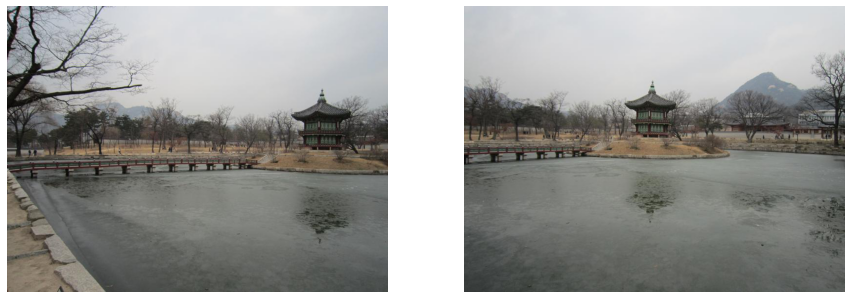

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# (a) Compute ORB Features and Match Keypoints

In [ ]:
def get_orb_features(img):
  '''
    Compute ORB features using cv2 library functions
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
  '''
  # create ORB object
  orb = cv2.ORB_create()

  # identify the keypoints
  kp = orb.detect(img, None)

  # compute the descriptors
  keypoints, descriptors = orb.compute(img, kp)
  return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    Compute matches between feature descriptors of two images using ratio test. 
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # Create Brute Force Matcher
  bf = cv2.BFMatcher()
  all_matches = bf.knnMatch(desc_1, desc_2, k=2)

  # Apply ratio test
  matches = []
  for m,n in all_matches:
      if m.distance < ratio*n.distance:
          matches.append(m)
  return matches

keypoints for img1 and img2


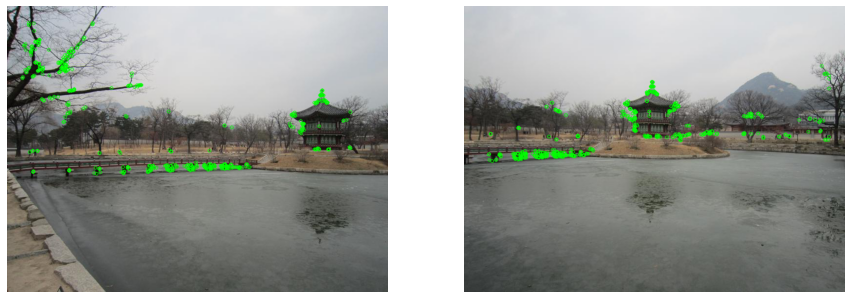

In [ ]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


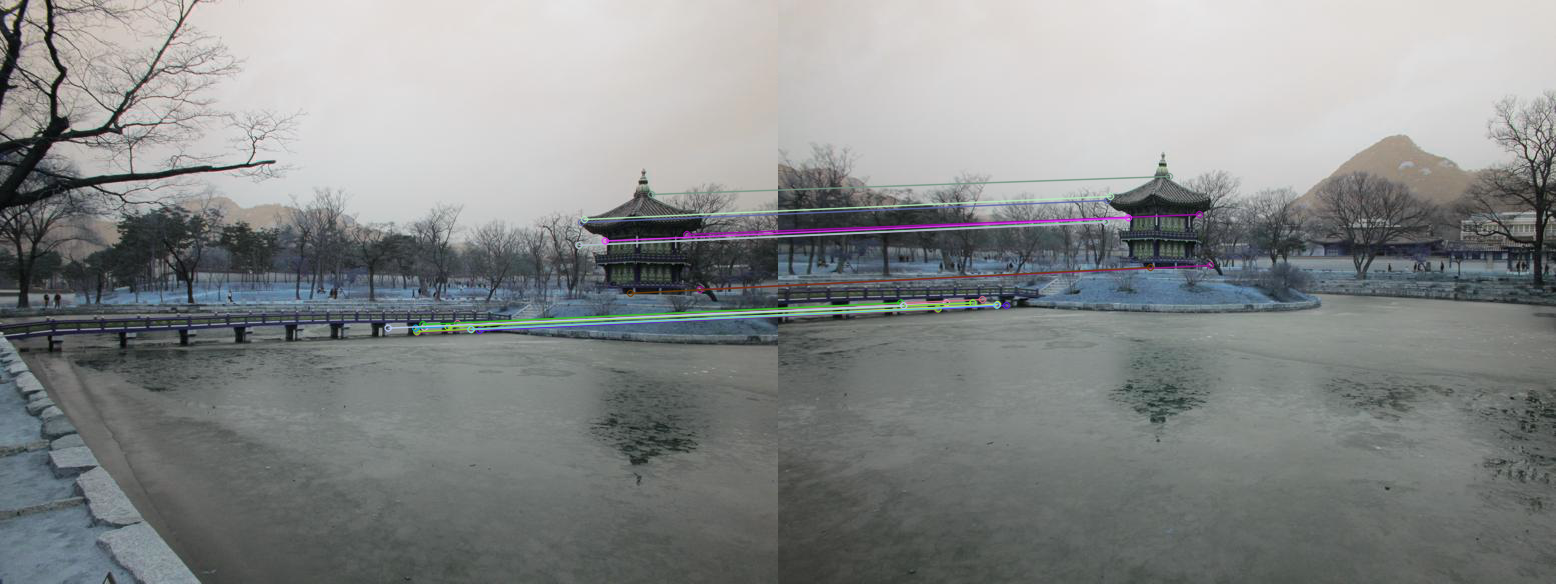

In [ ]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [ ]:
def find_homography(pts_1, pts_2):
  '''
    Find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_1: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''

  # Define helper functions
  def homog(pts):
    ones = np.ones((len(pts),1), dtype=float)
    homog_pts = np.concatenate([pts, ones], axis=1)
    return homog_pts
  
  def cart(pts):
    cart_pts = pts
    cart_pts[:,0] = pts[:,0] / pts[:,2]
    cart_pts[:,1] = pts[:,1] / pts[:,2]
    cart_pts = cart_pts[:,[0,1]]
    return cart_pts

  def func(x):
    H = x.reshape(3, 3)
    homog_pts = homog(pts_1)
    transform = np.matmul(H, homog_pts.T).T
    return np.array((pts_2 - cart(transform)).flatten())

  # Optimize
  x0 = np.ones(9)
  H = least_squares(func, x0).x.reshape(3, 3)

  # ===============================================
  return H

In [ ]:
def transform_ransac(pts_1, pts_2):
  '''
    Implements RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  # Define helper functions
  def homog(pts):
    ones = np.ones((len(pts),1), dtype=float)
    homog_pts = np.concatenate([pts, ones], axis=1)
    return homog_pts
  
  def cart(pts):
    cart_pts = pts
    cart_pts[:,0] = pts[:,0] / pts[:,2]
    cart_pts[:,1] = pts[:,1] / pts[:,2]
    cart_pts = cart_pts[:,[0,1]]
    return cart_pts

  N = 200
  epsilon = 2

  # RANSAC Loop
  best_num_inliers = 0
  iterations = 0
  while iterations < N:
    iterations += 1
    # Select four random feature pairs
    p1, p2, p3, p4 = random.sample(range(0, pts_1.shape[0]), 4)
    random1 = pts_1[[p1, p2, p3, p4], :]
    random2 = pts_2[[p1, p2, p3, p4], :]
    
    # Compute homography between them
    H = find_homography(random1, random2)
    
    # Count inliers
    product = np.matmul(H, homog(pts_1).T).T
    cart_product = cart(product)
    dist = np.linalg.norm(pts_2 - cart_product, axis=1)
    inliers = np.where(dist < epsilon)[0]

    # Store info if outperforms previous...
    if len(inliers) > best_num_inliers:
      best_inliers = inliers
      best_num_inliers = len(inliers)

  # Recompute H using only those inliers
  # Find inliers from best H
  best_model = find_homography(pts_1[best_inliers], pts_2[best_inliers])
  # ===============================================
  return best_model

# Panoramic Stitching

In [ ]:
def panoramic_stitching(img1, img2):
  '''
    Given a pair of overlapping images, generate a panoramic image. 
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # 1.detect keypoints and extract orb feature descriptors
  kp_1, desc_1 = get_orb_features(img1)
  kp_2, desc_2 = get_orb_features(img2)

  # 2.match features between two images
  matches = match_keypoints(desc_1, desc_2)

  # 3.compute homography matrix H transforming points from pts_2 to pts_1. Note the order here (not pts_1 to pts_2)!
  # extract pts_1
  coords_1 = [ kp_1[m.queryIdx].pt for m in matches ]
  pts_1 = np.array(coords_1, dtype=float)
  

  # Extract pts_2
  coords_2 = [ kp_2[m.trainIdx].pt for m in matches ]
  pts_2 = np.array(coords_2, dtype=float)

  # Compute Homography
  H = transform_ransac(pts_2, pts_1)

  # apply perspective wrap to stitch images together
  final_img = cv2.warpPerspective(img2, H, (img2.shape[1] + img1.shape[1], img2.shape[0] * 2))
  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

  return final_img


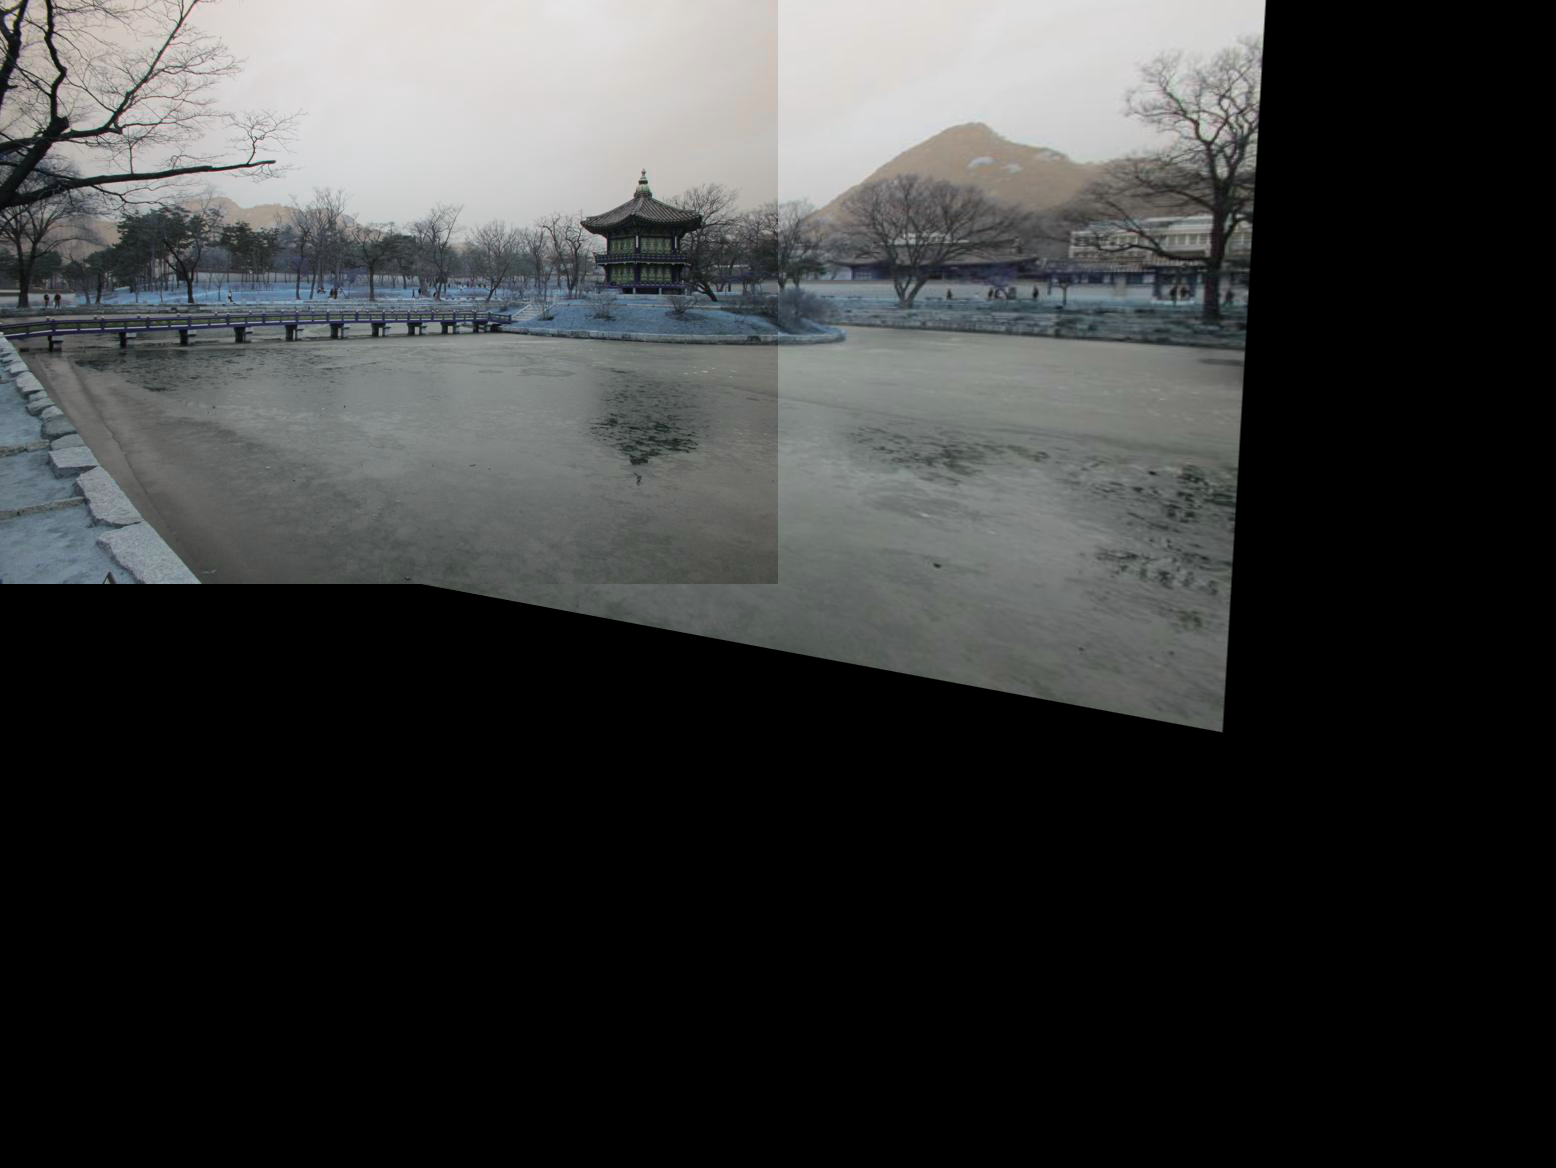

In [ ]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)